# Usage analysis for individual user

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Individual Analysis")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
#loading the data 
p_check = pd.read_csv('/content/gdrive/My Drive/Individual Analysis/individual-data/device_check_2.csv')
p_use = pd.read_csv('/content/gdrive/My Drive/Individual Analysis/individual-data/process_usage_3.csv')


In [ ]:
# consists of phone unlocked count and screen on time per day
p_check.head()

,Date,Check phone count,Screen on time
0,27/11/2019,30.0,3:17:07
1,26/11/2019,55.0,3:56:09
2,25/11/2019,79.0,5:11:51
3,24/11/2019,68.0,5:07:07
4,23/11/2019,66.0,5:52:24


In [ ]:
# show the head 10 rows of this dataset, which consists the detailed time and duration each process (activity)
p_use.head(10)

,App name,Date,Time,Duration
0,App Usage,26/11/2019,20:06:27,0:01:01
1,Weibo,26/11/2019,20:05:43,0:00:23
2,Mail,26/11/2019,20:05:02,0:00:35
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00
4,Screen on (locked),26/11/2019,20:05:01,0:00:01
5,Screen off (locked),26/11/2019,20:01:11,0:03:50
6,Mail,26/11/2019,20:00:43,0:00:28
7,Gallery,26/11/2019,20:00:31,0:00:09
8,Mail,26/11/2019,19:59:26,0:01:05
9,Gallery,26/11/2019,19:59:24,0:00:01


# Data Pre-Processing

Data Cleaning


In [ ]:
#renaming the columns name
p_check.rename(columns={'Check phone count': 'check_phn_count', 'Screen on time': 'screen_on_time'}, inplace=True)
#droping the NaN columns
p_check.dropna(axis=0, inplace =True)

Converting the screen time on to minutes 

In [ ]:
p_check['duration'] = p_check['screen_on_time'].str.split(':').apply(lambda x: int(x[0]) *60 + int(x[1])  )
p_check.describe()

,check_phn_count,duration
count,126.000000,126.000000
mean,73.523810,338.833333
std,16.977969,139.054737
min,19.000000,37.000000
25%,63.000000,275.000000
50%,71.000000,332.000000
75%,81.000000,374.750000
max,158.000000,1580.000000


Duration indicated the minutes used every day. here as a cleaning process, assuming the person does not use mobile more 11hrs(660minutes) per day. if it exists 11hours then it is replaced with the median of duration

In [ ]:
# User does not spend his time more than 11 hours per day.  
p_check.loc[p_check['duration'] > 660, 'duration'] = p_check['duration'].median()
p_check.describe()

,check_phn_count,duration
count,126.000000,126.000000
mean,73.523810,328.928571
std,16.977969,83.148944
min,19.000000,37.000000
25%,63.000000,275.000000
50%,71.000000,332.000000
75%,81.000000,373.750000
max,158.000000,570.000000


From the above information, the user unlocks the phone approximately 72 times per day and he uses phone approximately 5.5hrs(336 minutes) per day

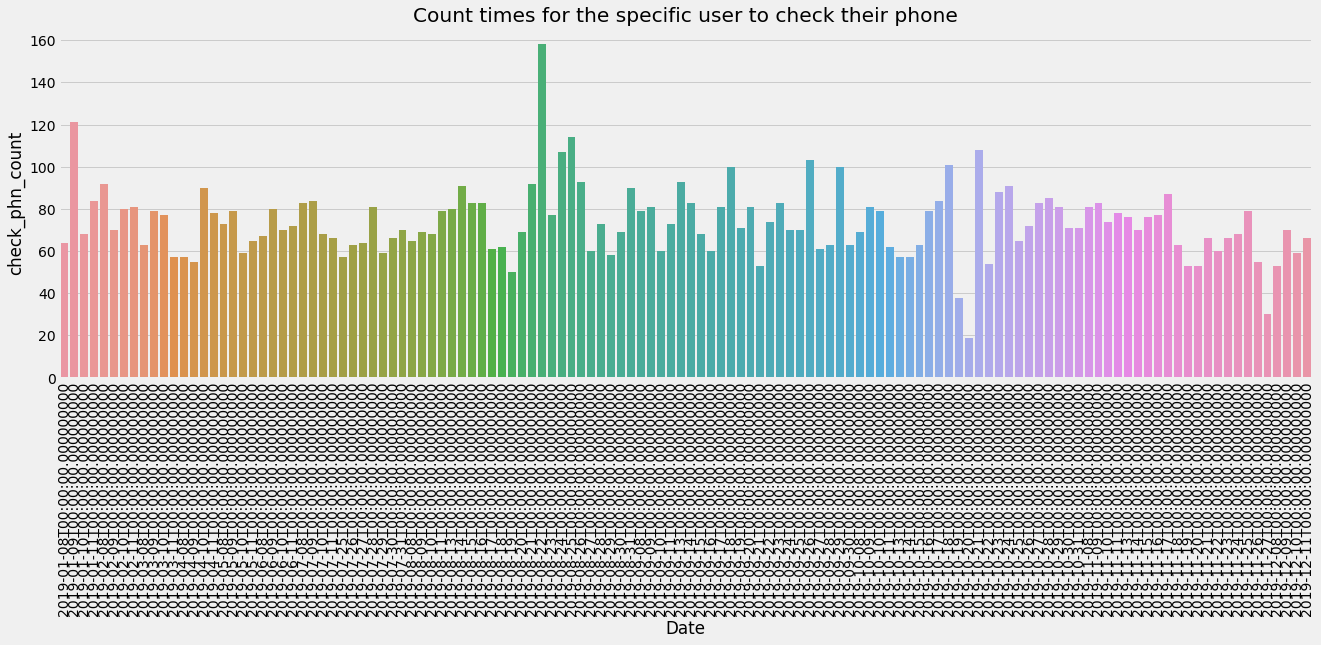

In [ ]:
p_check["Date"]= pd.to_datetime(p_check["Date"]) 
#Bar plot with respect to date and the phone check count
plt.figure(figsize=(20,6))
sns.barplot(x="Date", y="check_phn_count", data=p_check)
plt.title('Count times for the specific user to check their phone')
plt.xticks(rotation=90)
plt.show()

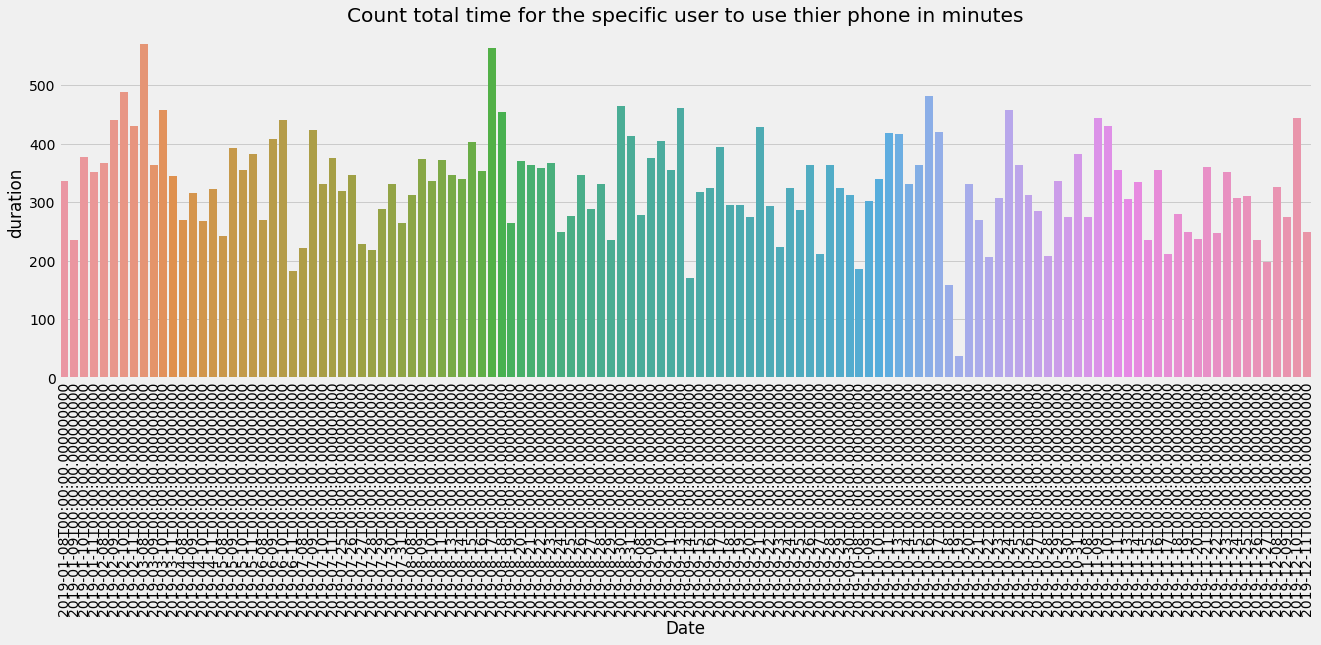

In [ ]:
#Bar plot with respect to date and the phone usage duration everyday
plt.figure(figsize=(20,6))
sns.barplot(x="Date", y="duration", data=p_check)
plt.title('Count total time for the specific user to use thier phone in minutes')
plt.xticks(rotation=90)
plt.show()

In [ ]:
## converting the date column from object to time series  
p_check['Date'] = pd.to_datetime(p_check['Date'])
p_check['day_of_week'] = p_check['Date'].dt.dayofweek + 1

,Date,check_phn_count,screen_on_time,duration,day_of_week
0,2019-11-27,30.0,3:17:07,197.0,3
1,2019-11-26,55.0,3:56:09,236.0,2
2,2019-11-25,79.0,5:11:51,311.0,1
3,2019-11-24,68.0,5:07:07,307.0,7
4,2019-11-23,66.0,5:52:24,352.0,6
...,...,...,...,...,...
121,2019-07-29,59.0,4:48:43,288.0,1
122,2019-07-28,81.0,3:39:34,219.0,7
123,2019-07-27,64.0,3:49:00,229.0,6
124,2019-07-26,63.0,5:47:43,347.0,5


In [ ]:
# Check the count and duration group by week and order them by duration
p_check.groupby('day_of_week').sum().nlargest(20,'duration').reset_index()

,day_of_week,check_phn_count,duration
0,7,1335.0,6199.0
1,5,1339.0,6196.0
2,4,1347.0,6050.0
3,1,1377.0,5873.0
4,2,1195.0,5745.0
5,6,1206.0,5714.0
6,3,1465.0,5668.0


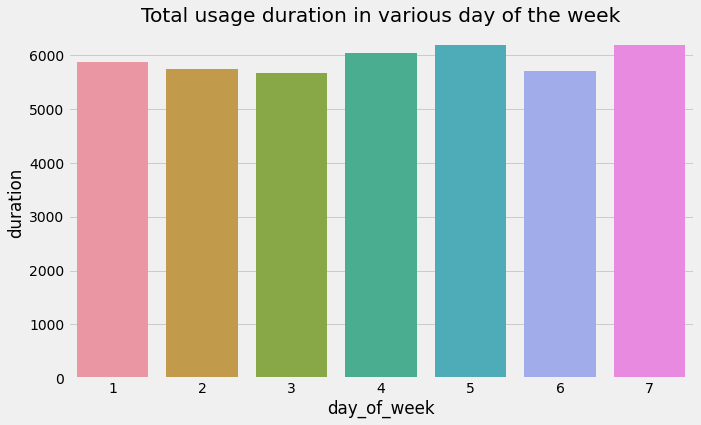

In [ ]:
# Plot the previous data
plt.figure(figsize=(10,6))
data = p_check.groupby('day_of_week').sum().nlargest(20,'duration').reset_index()
sns.barplot(x='day_of_week',y='duration',data=data)
plt.title('Total usage duration in various day of the week')
plt.show()

Result: the figure above compare the duration in various day of the week. Notice that this user shows higher usage on Thursday and Sunday.

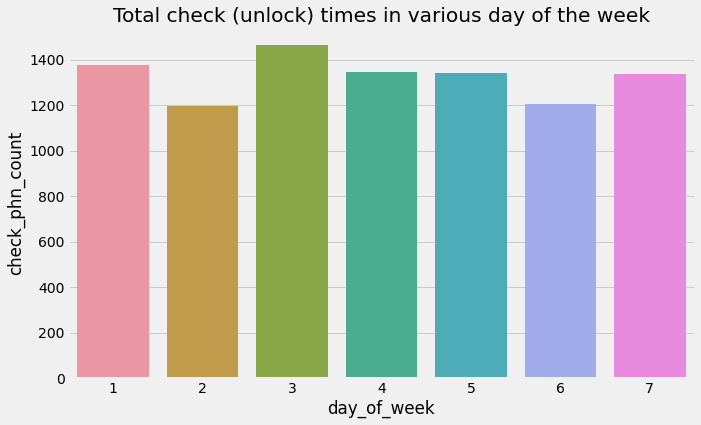

In [ ]:
plt.figure(figsize=(10,6))
data = p_check.groupby('day_of_week').sum().nlargest(20,'check_phn_count').reset_index()
sns.barplot(x='day_of_week',y='check_phn_count',data=data)
plt.title('Total check (unlock) times in various day of the week')
plt.show()

Result: the figure above compare the total check times in various day of the week. Notice that this user shows higher usage on Wednesday and Sunday.

In [ ]:
# Add a new attribute to show a day is weekday (0) or weekend (1) 
p_check['categories'] = p_check['day_of_week'].apply(lambda x: 'weekday' if x < 6 else 'weekend')
p_check['weekday'] = p_check['categories'].apply(lambda x: '0' if x == 'weekday' else '1')
p_check.drop(columns='categories', inplace=True)
p_check

,Date,check_phn_count,screen_on_time,duration,day_of_week,weekday
0,2019-11-27,30.0,3:17:07,197.0,3,0
1,2019-11-26,55.0,3:56:09,236.0,2,0
2,2019-11-25,79.0,5:11:51,311.0,1,0
3,2019-11-24,68.0,5:07:07,307.0,7,1
4,2019-11-23,66.0,5:52:24,352.0,6,1
...,...,...,...,...,...,...
121,2019-07-29,59.0,4:48:43,288.0,1,0
122,2019-07-28,81.0,3:39:34,219.0,7,1
123,2019-07-27,64.0,3:49:00,229.0,6,1
124,2019-07-26,63.0,5:47:43,347.0,5,0


In [ ]:
# Add a new attribute to represent the month
p_check['month'] = pd.DatetimeIndex(p_check['Date']).month
p_check.head()

,Date,check_phn_count,screen_on_time,duration,day_of_week,weekday,month
0,2019-11-27,30.0,3:17:07,197.0,3,0,11
1,2019-11-26,55.0,3:56:09,236.0,2,0,11
2,2019-11-25,79.0,5:11:51,311.0,1,0,11
3,2019-11-24,68.0,5:07:07,307.0,7,1,11
4,2019-11-23,66.0,5:52:24,352.0,6,1,11


#### Loading the phone usage dataset, it present the usage detail by each activity of the user

In [ ]:
p_use.head(10)

,App name,Date,Time,Duration
0,App Usage,26/11/2019,20:06:27,0:01:01
1,Weibo,26/11/2019,20:05:43,0:00:23
2,Mail,26/11/2019,20:05:02,0:00:35
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00
4,Screen on (locked),26/11/2019,20:05:01,0:00:01
5,Screen off (locked),26/11/2019,20:01:11,0:03:50
6,Mail,26/11/2019,20:00:43,0:00:28
7,Gallery,26/11/2019,20:00:31,0:00:09
8,Mail,26/11/2019,19:59:26,0:01:05
9,Gallery,26/11/2019,19:59:24,0:00:01


In [ ]:
#re-name the columns
ph_usage.rename(columns={'App name': 'App_name'}, inplace=True)

In [ ]:
ph_usage.describe()

,App_name,Date,Time,Duration
count,59303,59301,59301,59301
unique,134,125,37433,2172
top,Screen on (locked),22/08/2019,06:40:03,0:00:01
freq,12041,907,17,9535


In [ ]:
ph_usage.shape

(59304, 4)

In [ ]:
#droping the NaN columns
ph_usage.dropna(axis=0, inplace =True)

In [ ]:
#making a new copy of data frame
ph_usg = ph_usage

In [ ]:
# Creating a new column of datetime (timestamp)
ph_usg['DateTime']= pd.to_datetime(ph_usg['Date'] +" " + ph_usg['Time'],format='%d/%m/%Y %H:%M:%S')

In [ ]:
# Converting the duration into seconds.
ph_usg['usage_seconds'] = ph_usg['Duration'].str.split(':').apply(lambda x: int(x[0]) *3600 + int(x[1]) * 60 + int(x[2]))
ph_usg

,App_name,Date,Time,Duration,DateTime,usage_seconds
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61
1,Weibo,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23
2,Mail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02,0
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01,1
...,...,...,...,...,...,...
59296,Screen off (locked),25/07/2019,06:20:19,0:01:56,2019-07-25 06:20:19,116
59297,Clock,25/07/2019,06:20:03,0:00:17,2019-07-25 06:20:03,17
59298,Screen on (locked),25/07/2019,06:20:02,0:00:01,2019-07-25 06:20:02,1
59299,Screen off (locked),25/07/2019,06:13:05,0:06:57,2019-07-25 06:13:05,417


In [ ]:
# to find the number of days
ph_usg['DateTime'].max() - ph_usg['DateTime'].min()

Timedelta('124 days 13:53:41')

In [ ]:
#Filtering the actual apps and system activity usage
system_tracker = ['Screen on (unlocked)','Screen off (locked)','Screen on (locked)', 'Screen off','Permission controller','System UI','Package installer',
'Device shutdown','Call Management']
service_app = ph_usg[ph_usg['App_name'].isin(system_tracker)]
service_app

,App_name,Date,Time,Duration,DateTime,usage_seconds
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02,0
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01,1
5,Screen off (locked),26/11/2019,20:01:11,0:03:50,2019-11-26 20:01:11,230
10,Screen on (unlocked),26/11/2019,19:58:44,0:00:00,2019-11-26 19:58:44,0
11,Screen on (locked),26/11/2019,19:58:43,0:00:01,2019-11-26 19:58:43,1
...,...,...,...,...,...,...
59295,Screen on (locked),25/07/2019,06:22:16,0:00:01,2019-07-25 06:22:16,1
59296,Screen off (locked),25/07/2019,06:20:19,0:01:56,2019-07-25 06:20:19,116
59298,Screen on (locked),25/07/2019,06:20:02,0:00:01,2019-07-25 06:20:02,1
59299,Screen off (locked),25/07/2019,06:13:05,0:06:57,2019-07-25 06:13:05,417


Analysis of the system build-in activity

In [ ]:
#Getting all the user apps.
all_apps = ph_usg[~ph_usg['App_name'].isin(system_tracker)]
all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61
1,Weibo,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23
2,Mail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35
6,Mail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28
7,Gallery,26/11/2019,20:00:31,0:00:09,2019-11-26 20:00:31,9
...,...,...,...,...,...,...
59285,Weibo,25/07/2019,08:02:10,0:00:00,2019-07-25 08:02:10,0
59288,Weibo,25/07/2019,07:58:43,0:03:11,2019-07-25 07:58:43,191
59292,Weibo,25/07/2019,06:48:45,0:06:05,2019-07-25 06:48:45,365
59293,QQ Browser,25/07/2019,06:22:52,0:25:38,2019-07-25 06:22:52,1538


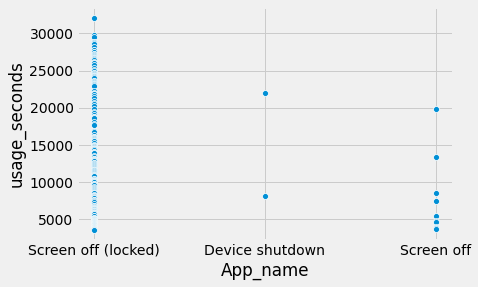

In [ ]:
#sorting the usage seconds in descending order, > 1 hour
test = service_app.sort_values(by='usage_seconds',ascending=0)
sns.scatterplot(x='App_name', y='usage_seconds', data=test[test['usage_seconds'] > 3600])

Result: for time duration, screen off(locked) is the most which means the users not use his phone for most of time, more than power off.

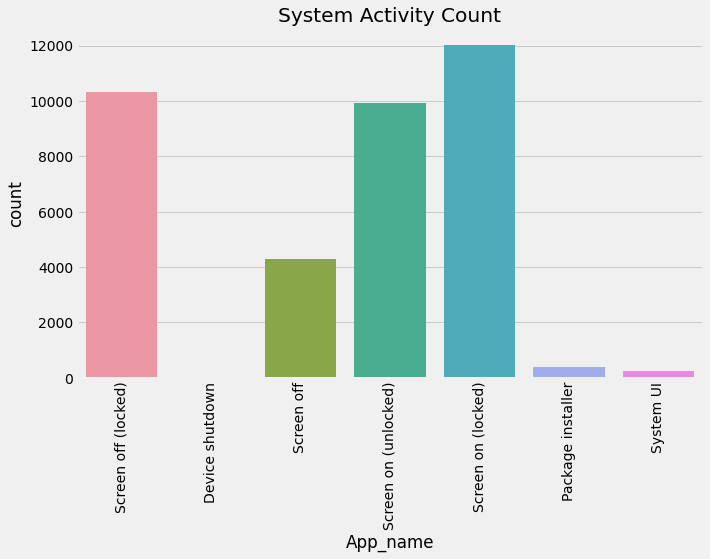

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(test['App_name'])
plt.title('System Activity Count')
plt.xticks(rotation=90)
plt.show()

Result: This is used to show the count for each system activity, notice that the lock/unlock operation is very frequent.

### Select not active activity to analyze the sleep pattern

In [ ]:
# Not in active activity
sleep = ['Screen off (locked)','Screen on (locked)', 'Screen off']
sleep_duration = service_app[service_app['App_name'].isin(sleep)]
sleep_duration

,App_name,Date,Time,Duration,DateTime,usage_seconds
4,Screen on (locked),26/11/2019,20:05:01,0:00:01,2019-11-26 20:05:01,1
5,Screen off (locked),26/11/2019,20:01:11,0:03:50,2019-11-26 20:01:11,230
11,Screen on (locked),26/11/2019,19:58:43,0:00:01,2019-11-26 19:58:43,1
12,Screen off (locked),26/11/2019,19:32:25,0:26:18,2019-11-26 19:32:25,1578
15,Screen off,26/11/2019,19:17:24,0:13:51,2019-11-26 19:17:24,831
...,...,...,...,...,...,...
59295,Screen on (locked),25/07/2019,06:22:16,0:00:01,2019-07-25 06:22:16,1
59296,Screen off (locked),25/07/2019,06:20:19,0:01:56,2019-07-25 06:20:19,116
59298,Screen on (locked),25/07/2019,06:20:02,0:00:01,2019-07-25 06:20:02,1
59299,Screen off (locked),25/07/2019,06:13:05,0:06:57,2019-07-25 06:13:05,417


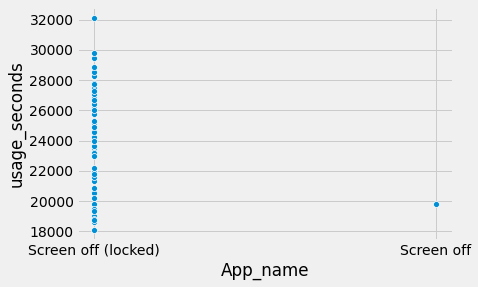

In [ ]:
sns.scatterplot(x='App_name', y='usage_seconds', data=sleep_duration[sleep_duration['usage_seconds'] > 18000])

In [ ]:
# Not active more than 5 hours, may be in long time sleep
new = sleep_duration[sleep_duration['usage_seconds'] > 18000]
new

,App_name,Date,Time,Duration,DateTime,usage_seconds
759,Screen off (locked),25/11/2019,00:02:41,5:13:29,2019-11-25 00:02:41,18809
1562,Screen off (locked),22/11/2019,23:25:14,5:10:28,2019-11-22 23:25:14,18628
2433,Screen off (locked),21/11/2019,00:01:42,6:26:20,2019-11-21 00:01:42,23180
2710,Screen off (locked),20/11/2019,00:13:23,5:42:59,2019-11-20 00:13:23,20579
3011,Screen off (locked),18/11/2019,23:40:44,7:14:19,2019-11-18 23:40:44,26059
...,...,...,...,...,...,...
56252,Screen off (locked),31/07/2019,22:41:18,6:55:16,2019-07-31 22:41:18,24916
56635,Screen off (locked),30/07/2019,23:40:18,6:39:46,2019-07-30 23:40:18,23986
57121,Screen off (locked),29/07/2019,21:59:49,8:00:57,2019-07-29 21:59:49,28857
57976,Screen off (locked),27/07/2019,23:22:53,7:41:56,2019-07-27 23:22:53,27716


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


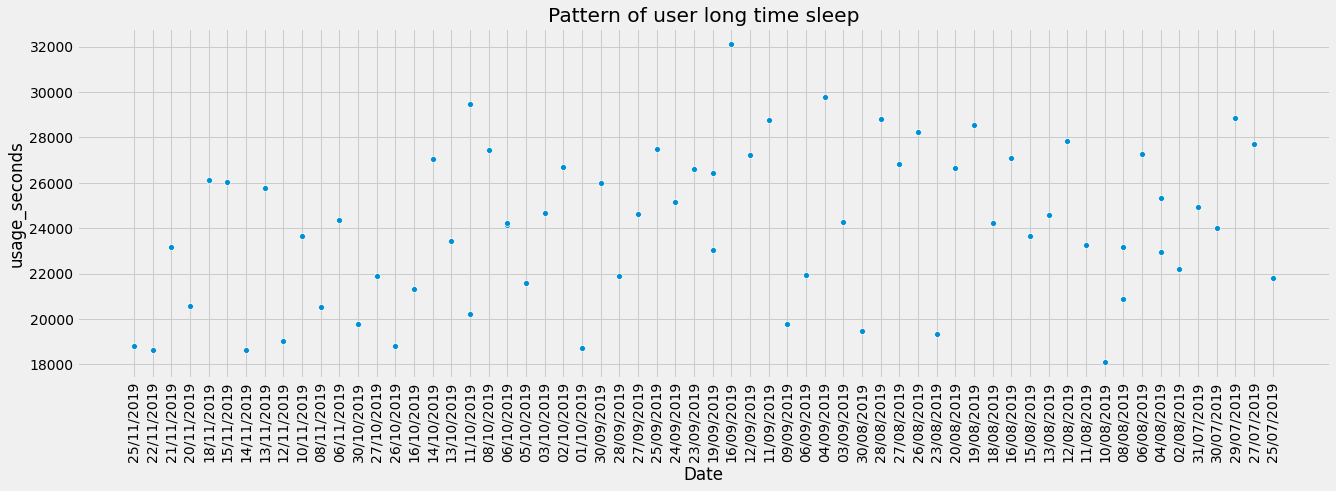

In [ ]:
plt.figure(figsize=(20,6))
sns.scatterplot(x='Date', y='usage_seconds', data=new)
plt.title('Pattern of user long time sleep')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#The user approximately sleeps 6.7 hours everyday.. since the screen off was filtered more than 5 hours. all the time are showing around 10PM to 1AM
new.usage_seconds.mean()

24142.75

Result: The user sleeps approximately 6.7 hours in one day (night)
since the screen off was filtered more than 5 hours. all the time are showing around 11PM to 1AM
if the user sleeps around 11PM to 1AM and his sleeping hours approximately 7 hours, then obviously he will wake up by 6AM to 8AM


### Select unlock activity to analyze the "active status (not in sleep)" for users

In [ ]:
# Getting the screen on unlocked alone
wake = ['Screen on (unlocked)']
wake_up = service_app[service_app['App_name'].isin(wake)]
wake_up

,App_name,Date,Time,Duration,DateTime,usage_seconds
3,Screen on (unlocked),26/11/2019,20:05:02,0:00:00,2019-11-26 20:05:02,0
10,Screen on (unlocked),26/11/2019,19:58:44,0:00:00,2019-11-26 19:58:44,0
14,Screen on (unlocked),26/11/2019,19:31:14,0:00:01,2019-11-26 19:31:14,1
21,Screen on (unlocked),26/11/2019,19:11:15,0:00:01,2019-11-26 19:11:15,1
44,Screen on (unlocked),26/11/2019,18:59:34,0:00:00,2019-11-26 18:59:34,0
...,...,...,...,...,...,...
59270,Screen on (unlocked),25/07/2019,09:14:39,0:00:05,2019-07-25 09:14:39,5
59273,Screen on (unlocked),25/07/2019,08:52:05,0:00:00,2019-07-25 08:52:05,0
59284,Screen on (unlocked),25/07/2019,08:02:10,0:10:40,2019-07-25 08:02:10,640
59289,Screen on (unlocked),25/07/2019,07:58:33,0:00:00,2019-07-25 07:58:33,0


In [ ]:
#Grouping the datetime on the basis of frequency day and getting the minimum time of the day
wakeup_time= wake_up.set_index('DateTime').groupby(pd.Grouper(freq='D')).min()
wakeup_time.tail(50)

,App_name,Date,Time,Duration,usage_seconds
DateTime,,,,,
2019-10-08,Screen on (unlocked),08/10/2019,01:04:21,0:00:00,0
2019-10-09,Screen on (unlocked),09/10/2019,06:21:28,0:00:00,0
2019-10-10,Screen on (unlocked),10/10/2019,05:56:52,0:00:00,0
2019-10-11,Screen on (unlocked),11/10/2019,06:15:21,0:00:00,0
2019-10-12,Screen on (unlocked),12/10/2019,06:50:02,0:00:00,0
2019-10-13,Screen on (unlocked),13/10/2019,04:08:11,0:00:00,0
2019-10-14,Screen on (unlocked),14/10/2019,05:48:29,0:00:00,0
2019-10-15,Screen on (unlocked),15/10/2019,06:02:08,0:00:00,0
2019-10-16,Screen on (unlocked),16/10/2019,02:02:20,0:00:00,0


Result: it shows the user wakeup around 6AM to 8AM. Although sometimes he wakeup between 2AM to 3AM

### Select the usage more than 15 seconds, means not a "flick transfer"

In [ ]:
#Filtering the app usage seconds more than 10 seconds. Assuming that user use apps more than 15 seconds. 
all_apps = all_apps[(all_apps.usage_seconds > 15)]
all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61
1,Weibo,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23
2,Mail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35
6,Mail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28
8,Mail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,65
...,...,...,...,...,...,...
59282,Weibo,25/07/2019,08:12:51,0:03:02,2019-07-25 08:12:51,182
59288,Weibo,25/07/2019,07:58:43,0:03:11,2019-07-25 07:58:43,191
59292,Weibo,25/07/2019,06:48:45,0:06:05,2019-07-25 06:48:45,365
59293,QQ Browser,25/07/2019,06:22:52,0:25:38,2019-07-25 06:22:52,1538


In [ ]:
#All apps access count
all_apps['App_name'].value_counts()

Weibo               3444
WeChat              3355
Phone               1721
iQiyi                721
UC Browser           455
                    ... 
Pushbullet             1
Samsung Keyboard       1
ColorNote              1
Sound picker           1
WordPress              1
Name: App_name, Length: 103, dtype: int64

Result: see most frequent use apps

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2997 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2992 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3016 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2986 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2975 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2990 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 3021 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backe

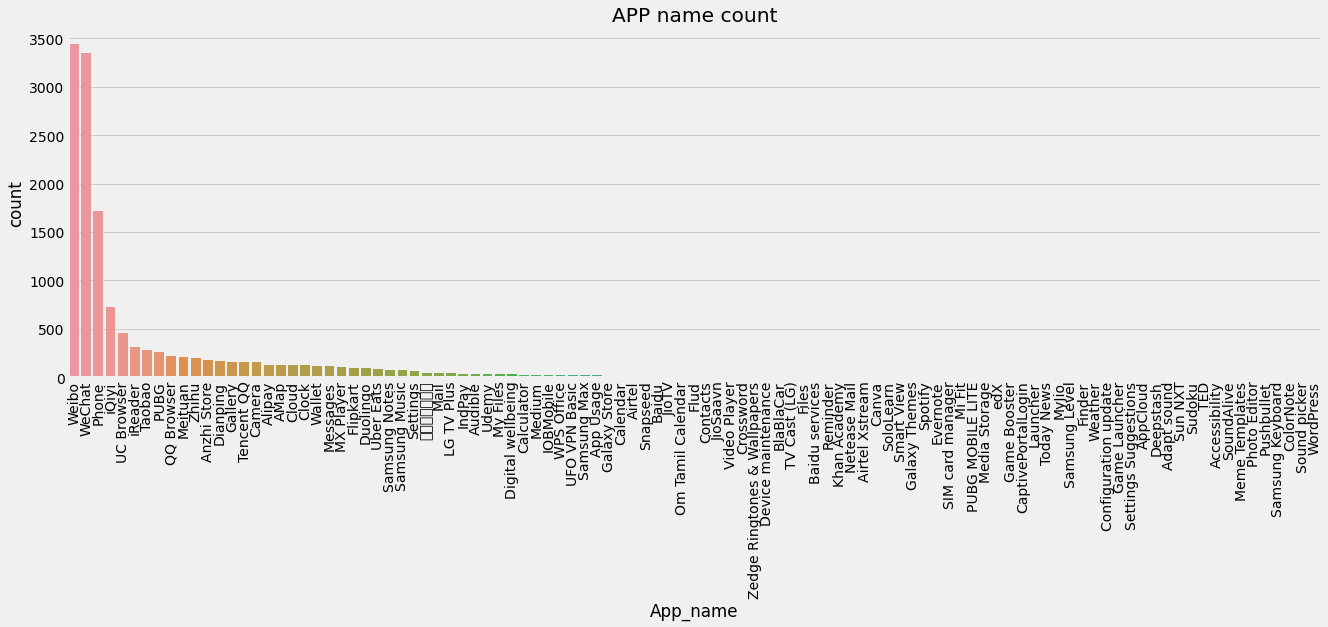

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x = 'App_name',
              data = all_apps,
              order = all_apps['App_name'].value_counts().index)

plt.title('APP name count')
plt.xticks(rotation=90)
plt.show()

Most frequent 20 apps

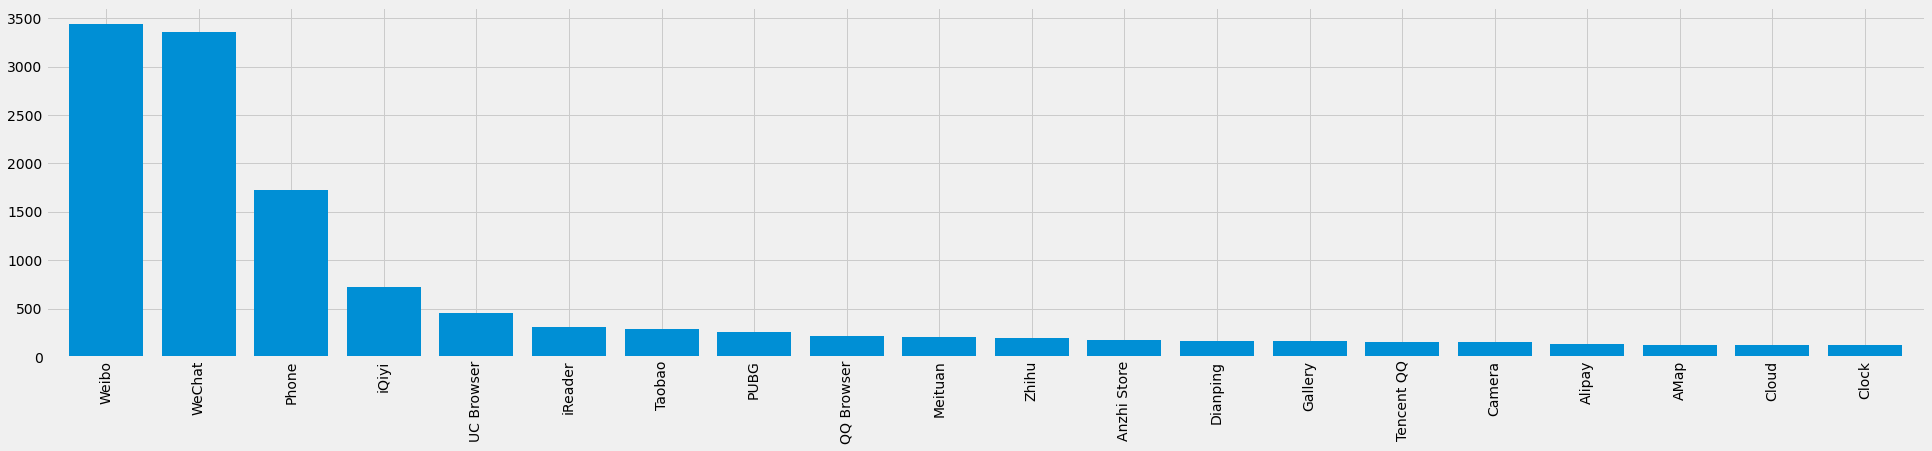

In [ ]:
plt.figure(figsize=(30,6))
s = all_apps['App_name'].value_counts().head(20)
ax= s.plot.bar(width=.8) 

In [ ]:
all_apps['usage_minutes'] = all_apps['usage_seconds']//60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



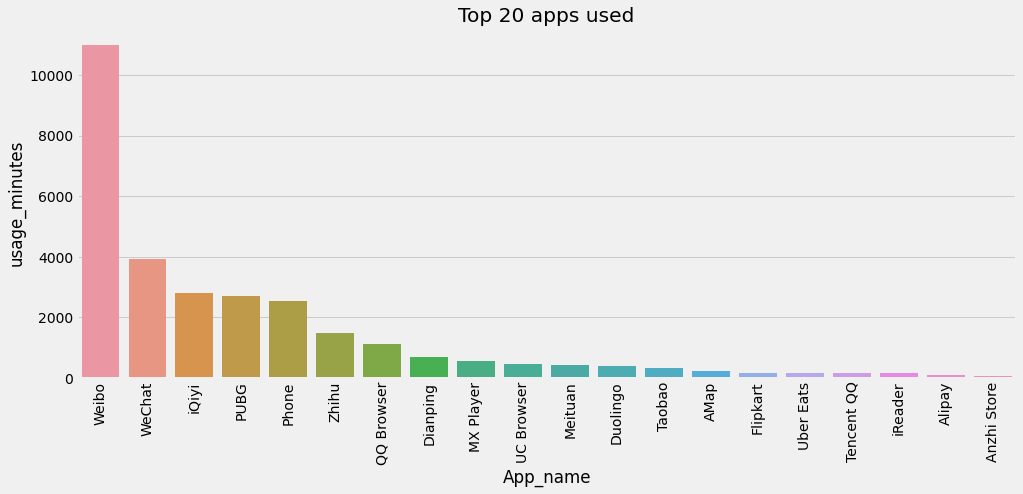

In [ ]:
plt.figure(figsize=(15,6))
data = all_apps.groupby('App_name').sum().nlargest(20,'usage_minutes').reset_index()
sns.barplot(x='App_name',y='usage_minutes',data=data)
plt.title('Top 20 apps used')
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_apps.groupby('App_name').sum().nlargest(20,'usage_minutes').reset_index()

,App_name,usage_seconds,usage_minutes
0,Weibo,763050,11009
1,WeChat,334917,3927
2,iQiyi,190214,2811
3,PUBG,169113,2691
4,Phone,204555,2533
5,Zhihu,93920,1477
6,QQ Browser,73908,1118
7,Dianping,45869,683
8,MX Player,36276,554
9,UC Browser,41643,470


In [ ]:
def dateFeatures(all_apps):
    features = ['day','week','dayofweek','month','weekofyear']
    for col in features:
        all_apps[col] = getattr(all_apps['DateTime'].dt,col) * 1

In [ ]:
dateFeatures(all_apps)
all_apps

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,App_name,Date,Time,Duration,DateTime,usage_seconds,usage_minutes,day,week,dayofweek,month,weekofyear
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61,1,26,48,1,11,48
1,Weibo,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23,0,26,48,1,11,48
2,Mail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35,0,26,48,1,11,48
6,Mail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28,0,26,48,1,11,48
8,Mail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,65,1,26,48,1,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...
59282,Weibo,25/07/2019,08:12:51,0:03:02,2019-07-25 08:12:51,182,3,25,30,3,7,30
59288,Weibo,25/07/2019,07:58:43,0:03:11,2019-07-25 07:58:43,191,3,25,30,3,7,30
59292,Weibo,25/07/2019,06:48:45,0:06:05,2019-07-25 06:48:45,365,6,25,30,3,7,30
59293,QQ Browser,25/07/2019,06:22:52,0:25:38,2019-07-25 06:22:52,1538,25,25,30,3,7,30


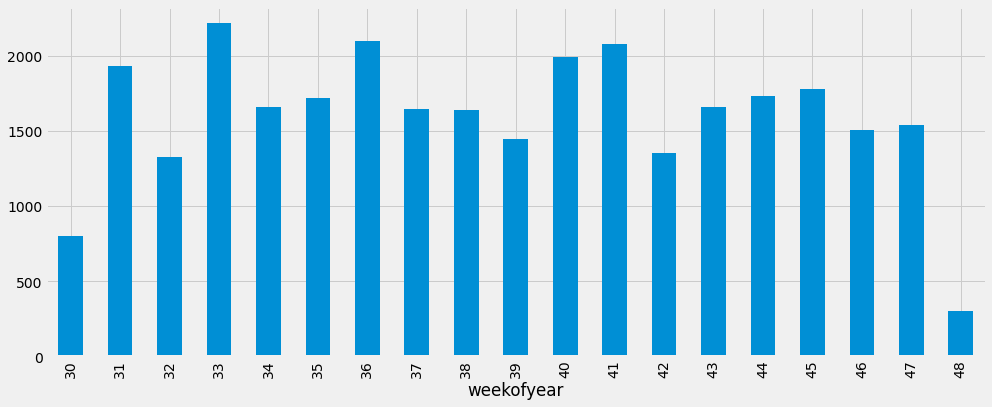

In [ ]:
plt.figure(figsize=(15,6))
all_apps.groupby(['weekofyear'])['usage_minutes'].sum().plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

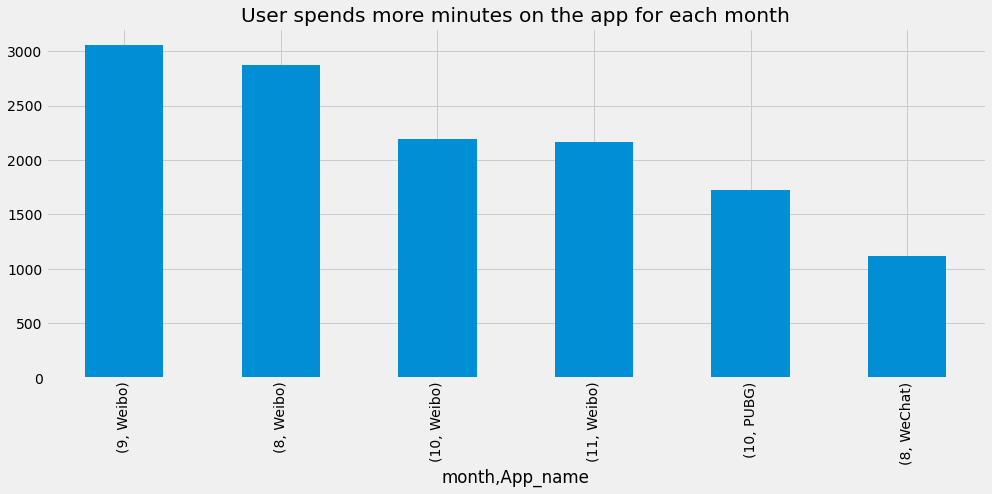

In [ ]:
plt.figure(figsize=(15,6))
all_apps.groupby(['month','App_name']).sum().nlargest(6,'usage_minutes')['usage_minutes'].plot(kind='bar')
plt.title('User spends more minutes on the app for each month')
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_apps

,App_name,Date,Time,Duration,DateTime,usage_seconds,usage_minutes,day,week,dayofweek,month,weekofyear
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,61,1,26,48,1,11,48
1,Weibo,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,23,0,26,48,1,11,48
2,Mail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,35,0,26,48,1,11,48
6,Mail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,28,0,26,48,1,11,48
8,Mail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,65,1,26,48,1,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...
59282,Weibo,25/07/2019,08:12:51,0:03:02,2019-07-25 08:12:51,182,3,25,30,3,7,30
59288,Weibo,25/07/2019,07:58:43,0:03:11,2019-07-25 07:58:43,191,3,25,30,3,7,30
59292,Weibo,25/07/2019,06:48:45,0:06:05,2019-07-25 06:48:45,365,6,25,30,3,7,30
59293,QQ Browser,25/07/2019,06:22:52,0:25:38,2019-07-25 06:22:52,1538,25,25,30,3,7,30


In [ ]:
train = all_apps.copy()

In [ ]:
def f(x):
    if (x > 5) and (x <= 8):
        return 'Early_Morn'
    elif (x > 8) and (x <= 12 ):
        return 'Morn'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Eve'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late_Night'

In [ ]:
train['hour'] = train['DateTime'].dt.hour
train['session'] = train['hour'].apply(f)
train.drop(['weekofyear','usage_seconds'],axis=1, inplace=True)

In [ ]:
train

,App_name,Date,Time,Duration,DateTime,usage_minutes,day,week,dayofweek,month,hour,session
0,App Usage,26/11/2019,20:06:27,0:01:01,2019-11-26 20:06:27,1,26,48,1,11,20,Eve
1,Weibo,26/11/2019,20:05:43,0:00:23,2019-11-26 20:05:43,0,26,48,1,11,20,Eve
2,Mail,26/11/2019,20:05:02,0:00:35,2019-11-26 20:05:02,0,26,48,1,11,20,Eve
6,Mail,26/11/2019,20:00:43,0:00:28,2019-11-26 20:00:43,0,26,48,1,11,20,Eve
8,Mail,26/11/2019,19:59:26,0:01:05,2019-11-26 19:59:26,1,26,48,1,11,19,Eve
...,...,...,...,...,...,...,...,...,...,...,...,...
59282,Weibo,25/07/2019,08:12:51,0:03:02,2019-07-25 08:12:51,3,25,30,3,7,8,Early_Morn
59288,Weibo,25/07/2019,07:58:43,0:03:11,2019-07-25 07:58:43,3,25,30,3,7,7,Early_Morn
59292,Weibo,25/07/2019,06:48:45,0:06:05,2019-07-25 06:48:45,6,25,30,3,7,6,Early_Morn
59293,QQ Browser,25/07/2019,06:22:52,0:25:38,2019-07-25 06:22:52,25,25,30,3,7,6,Early_Morn


In [ ]:
train.groupby(['session','Date','App_name']).size().reset_index()

,session,Date,App_name,0
0,Early_Morn,01/08/2019,Anzhi Store,1
1,Early_Morn,01/08/2019,Clock,2
2,Early_Morn,01/08/2019,Dianping,3
3,Early_Morn,01/08/2019,Meituan,1
4,Early_Morn,01/08/2019,WeChat,7
...,...,...,...,...
4546,Noon,31/08/2019,iQiyi,2
4547,Noon,31/10/2019,Camera,1
4548,Noon,31/10/2019,Phone,3
4549,Noon,31/10/2019,Samsung Notes,1


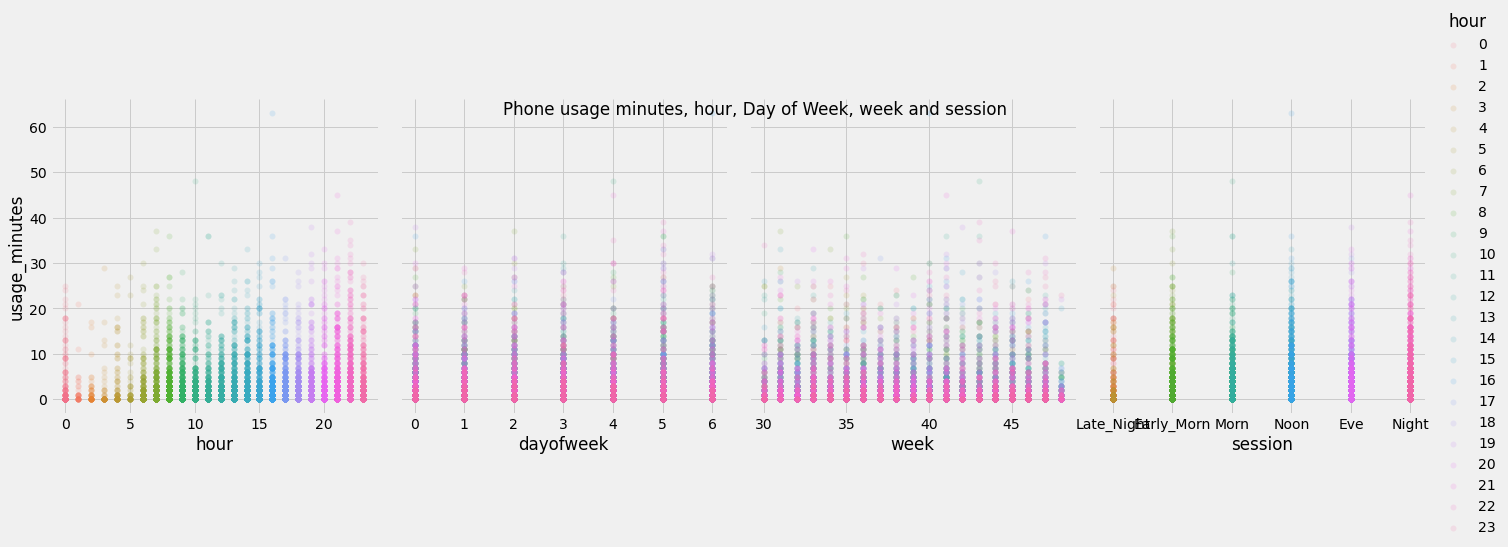

In [ ]:
sns.pairplot(train,
             hue='hour',
             x_vars=['hour','dayofweek','week','session'],
             y_vars='usage_minutes',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Phone usage minutes, hour, Day of Week, week and session')
plt.show()